# Classification of Citrus Diseases

> This notebook covers the necessary steps to experiment with a Neural Network towards a classification problem. We will be focusing on Citrus Leaves diseases, investigating a plain neural architecture to convert input images to a high-dimensional space. In this high-dimensional space, our representation is expected to be sparse, and separable into different classes.

We will approach the following:

- Unbalanced data
- Augmentations
- Convolutions and Linear Layers
- Dropout
- Activations (ReLU)
- SoftMax
- Loss Function with L2 Regularization
- ConfusionMatrix

# Dataset and Data Loader

In [1]:
from pathlib import Path, PosixPath
import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import torch
from random import shuffle

In [2]:
data_path = Path("/home/john_doe/msc/2_datasets/citrus/citrus_leaves")
images_folder = data_path / Path("orig_aug")
classes_desc = data_path / Path("classes.txt")

In [3]:
# Read classes to a dictionary
classes_dict = {}
with open(classes_desc, "r") as file:
    lines = file.readlines()
    for line in lines:
        class_id, class_description = line.strip().split(" ")
        classes_dict[int(class_id)] = class_description
        
print(classes_dict)

{1: 'blackspot', 2: 'canker', 3: 'greening', 4: 'healthy', 5: 'melanose'}


In [4]:
image_files = os.listdir(images_folder)
print(image_files[:10])

['000003_000145.png', '000004_000036.png', '000003_000063.png', '000003_000024.png', '000002_000107.png', '000001_000083.png', '000001_000158.png', '000004_000043.png', '000005_000096.png', '000002_000043.png']


Looking at image folders, we could see that images are organized as follows:

xxxxxx_yyyyyy.png

Where,

- xxxxxx stands for image class;
- yyyyyy stands for image id.

For example, 000003_000145.png stands for an image of class 3 (greening), and 000004_000036.png for an image of class 4 (healthy).

In [5]:
class_count = {1:0, 2:0, 3:0, 4:0, 5:0}

for image_file in image_files:
    image_class = int(image_file.split("_")[0])
    class_count[image_class] += 1
    
print(class_count)

{1: 171, 2: 163, 3: 204, 4: 174, 5: 112}


As we can see, some classes has more instances than others.

This is a problem of unbalanced data. We will need to tackle it during training.

Let us now implement our dataloader and dataset. As we have a different number of images for each class, we will separate 80% of each class for training, and 20% for testing.

In [6]:
images_by_class = {
    1:[], 2:[], 3:[], 4:[], 5:[]
}

for image_file in image_files:
    image_class = int(image_file.split("_")[0])
    images_by_class[image_class].append(image_file)

    
train_images_by_class = {}
test_images_by_class = {}

for class_id, class_images in images_by_class.items():
    n_train_images = int(0.8 * len(class_images))
    train_images_by_class[class_id] = class_images[:n_train_images]
    test_images_by_class[class_id] = class_images[n_train_images:]

# Merge images back into a single list
train_images = []
for images in train_images_by_class.values():
    train_images += images
shuffle(train_images)
test_images = []
for images in test_images_by_class.values():
    test_images += images
shuffle(test_images)

In [7]:
from torch.utils.data import Dataset
from typing import List, Union
from torchvision import transforms
from torchvision.transforms import InterpolationMode
import numpy as np
from torch.utils.data import DataLoader
from PIL import ImageOps

In [8]:
class ClassificationDataset(Dataset):
    def __init__(
        self,
        images_folder: PosixPath, # Path to images
        images: List[str], # List of images
        augmentation: False # Augment or not input images
    ) -> None:
        self.images_path = [images_folder / Path(image) for image in images]
        
        if augmentation == True:
            self.transforms = transforms.Compose([
                transforms.RandomAffine(
                    degrees=10, translate=(0.05,0.10), scale=(0.9,1.1), shear=(-2,2),
                    interpolation=transforms.InterpolationMode.BILINEAR, 
                    fill=0
                ),
                #transforms.RandomPerspective(),
                #transforms.ElasticTransform(),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                #transforms.ColorJitter(),
                transforms.GaussianBlur(3),
                transforms.ToTensor()
                #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        else:
            self.transforms = transforms.ToTensor()
        
    def __len__(self):
        return len(self.images_path)
    
    def __getitem__(self, idx):
        image_path = self.images_path[idx]
        label_ = int(image_path.stem.split("_")[0])
        label_one_hot = np.zeros(5)
        label_one_hot[label_ - 1] = 1
        
        image = self.transforms(Image.open(image_path))
        label = torch.Tensor(label_one_hot)
        
        return image, label

In [9]:
classification_dataset = ClassificationDataset(
    images_folder=images_folder,
    images=train_images,
    augmentation=True
)
classification_dataloader = DataLoader(
    classification_dataset, batch_size=8, shuffle=True
)

sample_train_images, sample_train_labels = next(iter(classification_dataloader))
print("Images shape => ", sample_train_images.shape)
print("Labels shape => ", sample_train_labels.shape)

Images shape =>  torch.Size([8, 3, 256, 256])
Labels shape =>  torch.Size([8, 5])


In [10]:
def visualize_random_batch(dataloader):
    batch_images, batch_labels = next(iter(dataloader))
    
    fig, axes = plt.subplots(2, 4, figsize=(16,8))
    for idx in range(8):
        image = batch_images[idx]
        image = image.transpose(0, 2)
        image = image.detach().cpu().numpy()
        image = (image * 255).astype(np.uint8)
        label = batch_labels[idx]
        label = label.detach().cpu().numpy()
        label = np.argmax(label) + 1
        title = classes_dict[label]
        
        # Plot Data
        axes[idx//4][idx%4].set_yticks([]),axes[idx//4][idx%4].set_xticks([])
        axes[idx//4][idx%4].set_title(title)
        axes[idx//4][idx%4].imshow(image)

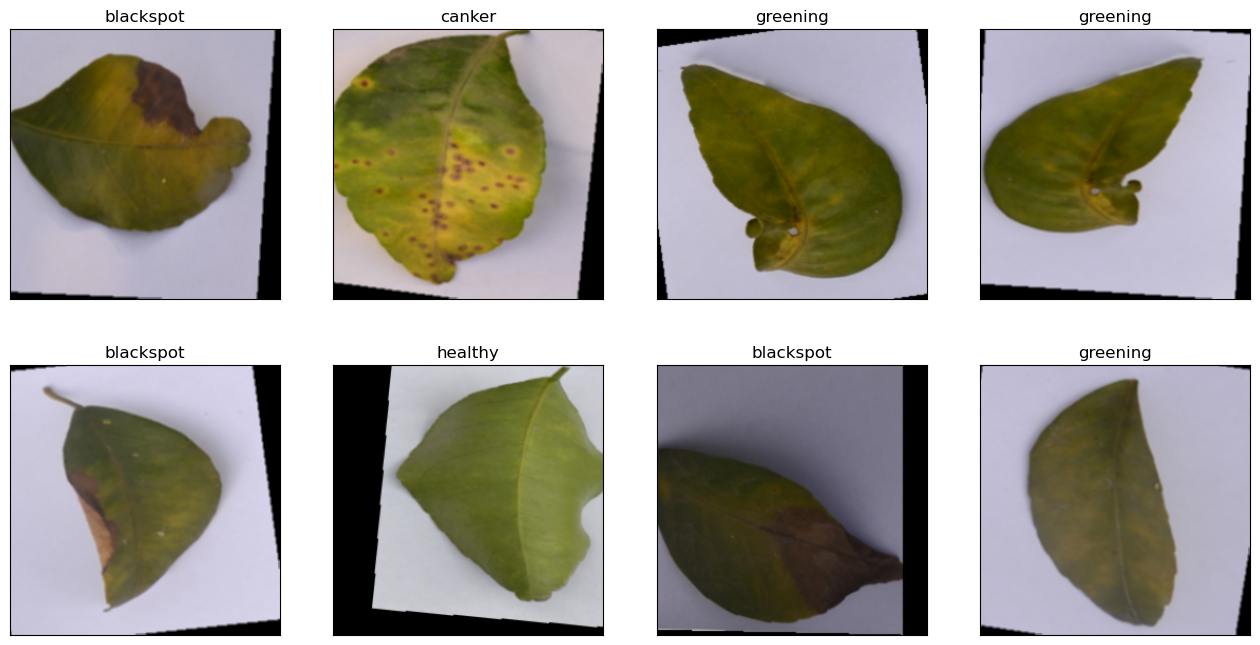

In [11]:
visualize_random_batch(classification_dataloader)

# Model

In [12]:
import torch
from torch import nn
from tifffile import imsave
import torch_snippets

In [13]:
def conv(
        in_channels:int,
        out_channels:int,
        kernel_size:int,
        padding:int=1
) -> torch.nn.modules.container.Sequential:
    return nn.Sequential(
        nn.Conv2d(
            in_channels, out_channels, kernel_size=kernel_size,
            stride=1, padding=padding),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=1)
    )

class ClassificationModel(nn.Module):
    def __init__(
        self, in_channels: int, # RGB or LAB -> 3 Channels
        n_kernels: List[int], # N Kernels by conv block
        kernel_sizes: List[int], # Kernel sizes by conv block
        fc_neurons: List[int], # N Neurons for FC (Fully Connected) Layers
        activations_path: PosixPath = None # Path to save activations
    ) -> None:
        super().__init__()
        self.activations_path = activations_path
        
        # Sets torch seed to guarantee Reproducibility
        random_seed = 7
        torch.manual_seed(random_seed)
        torch.cuda.manual_seed(random_seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
        # Classification Encoder        
        self.conv1 = conv(
            in_channels=in_channels, out_channels=n_kernels[0],
            kernel_size=kernel_sizes[0],padding=kernel_sizes[0]//2
        )
        self.conv2 = conv(
            in_channels=n_kernels[0], out_channels=n_kernels[1],
            kernel_size=kernel_sizes[1],padding=kernel_sizes[1]//2
        )
        self.conv3 = conv(
            in_channels=n_kernels[1], out_channels=n_kernels[2],
            kernel_size=kernel_sizes[2],padding=kernel_sizes[2]//2
        )
        
        # Classification Decoder (Classifier)
        self.classifier = nn.Sequential(
            nn.Linear(in_features=32*32*n_kernels[2], out_features=fc_neurons[0]),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(in_features=fc_neurons[0], out_features=fc_neurons[1]),
        )
        
        # Initialize weights (XAVIER)
        self._initialize_weights()
        
    def forward(self, x):
        # List to keep track of activations
        self.activations = []
        
        # Extract Features
        x = self.conv1(x)
        self.activations.append(x)
        x = self.conv2(x)
        self.activations.append(x)
        x = self.conv3(x)
        self.activations.append(x)
        
        #Flattens input tensor into a 2D tensor
        x = torch.flatten(x, start_dim=1)
        
        y = self.classifier(x)
        
        return y
        
    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                #get the number of elements in the layer weights
                n = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
                #initialize layer weights with random values generated from a normal
                #distribution with mean = 0 and std = sqrt(2. / n))
                m.weight.data.normal_(mean=0, std=np.sqrt(2. / n))
                if m.bias is not None:
                    #initialize bias with 0 
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                #initialize layer weights with random values generated from a normal
                #distribution with mean = 0 and std = 1/100
                m.weight.data.normal_(mean=0, std=0.01)
                if m.bias is not None:
                #initialize bias with 0 
                    m.bias.data.zero_()
                    
    def write_activation(
        self, image: np.ndarray, path: PosixPath, reshape: bool=False
    ) -> None:
        max_img = np.max(image)
        min_img = np.min(image)
        if (min_img != max_img):
            image = 255 * (image - min_img) / (max_img - min_img)
        image = image.astype(np.uint8)
        
        image = Image.fromarray(image)
        if reshape:
            image = image.resize((256, 256), Image.Resampling.NEAREST)
        image.save(path)
        
    # Save encoder activations
    @torch.no_grad()
    def save_activations(
        self, epoch: int,
        data_loader: torch.utils.data.dataloader.DataLoader
    ) -> None:
        activations_path = self.activations_path / Path(f"epoch_{epoch}")
        
        # Saving activations for each image
        print("[INFO] Saving activations!")
        images_path = data_loader.dataset.images_path
        to_tensor = transforms.ToTensor()
        for image_path in tqdm(images_path):
            image_name = image_path.stem
            saving_path = activations_path / Path(image_name) / Path("encoder")
            saving_path_reshape = activations_path / Path(image_name) / Path("encoder_reshape")
            os.makedirs(saving_path, exist_ok=True)
            os.makedirs(saving_path_reshape, exist_ok=True)
            
            image_data = to_tensor(Image.open(image_path))
            # Adds Batch Dimension
            image_data = torch.unsqueeze(image_data, dim=0)
            image_data = image_data.to("cuda")
            self.to("cuda")
            self.forward(image_data)
            
            # Save encoder activations
            for actv_idx, activations in enumerate(self.activations):
                activations = activations.cpu().detach().numpy()
                for ch_idx in range(activations.shape[1]):
                    channel_activations = activations[0, ch_idx, ...]
                    
                    filename = Path(f"layer_{actv_idx}_ch_{ch_idx}.png")
                    # Save normal size image
                    self.write_activation(
                        channel_activations, saving_path / filename
                    )
                    # Save with the same shape as input
                    self.write_activation(
                        channel_activations, saving_path_reshape / filename, True
                    )
                    
        # Save model weights
        torch.save(self.state_dict(), activations_path / Path("model.pth"))
        
    def save_curves(self, logger: torch_snippets.torch_loader.Report) -> None:
        _, ax = plt.subplots(figsize=(8, 6))
        logger.plot_epochs(["trn_loss"], ax=ax)
        savefig_path = self.activations_path / Path("loss.png")
        plt.savefig(savefig_path)
        
        _, ax = plt.subplots(figsize=(8, 6))
        logger.plot_epochs(["trn_accuracy"], ax=ax)
        savefig_path = self.activations_path / Path("accuracy.png")
        plt.savefig(savefig_path)

# Train Loop and Inference

In this section we will implement the following:

- Our training loop and our loss (with l2 regularization)
- Our inference method, to save or predictions and show evaluation metrics
- Visualization of last layers, to verify if convolutions transforms our data into a hight-dimensional sparse space

In [14]:
from torch_snippets import optim, Report
from torchsummary import summary

In [15]:
# Loss Function with L2 Regularization
def criterion(model, preds, targets, loss_function):
    loss_scalar = loss_function(preds, targets)
    
    # Add l2_regularization
    l2_regularization = 0
    for param in model.parameters():
        l2_regularization += torch.norm(param, 2)
    loss_scalar += 0.0001 * l2_regularization # 0.0001 is the weight_decay
    # Compute mean accuracy in the batch
    pred_labels = torch.max(preds, 1)[1] # same as argmax
    target_labels = torch.max(targets, 1)[1] # same as argmax
    acc = torch.sum(pred_labels == target_labels)
    n = pred_labels.size(0)
    acc = acc/n
    
    return loss_scalar, acc

In [16]:
def train_loop(
    epochs, model, dataloader, lr, loss_function,
    n_save_activations=200
):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to("cuda")
    logger = Report(epochs)
    
    for epoch in range(epochs):
        losses = []
        accuracies = []
        for batch in dataloader:
            model.train()
            image, ground_truth = batch
            image = image.to("cuda")
            ground_truth = ground_truth.to("cuda")
            prediction = model(image)
            optimizer.zero_grad()
            
            # Gets Loss and Accuracy
            loss, acc = criterion(model, prediction, ground_truth, loss_function)
            losses.append(loss)
            accuracies.append(acc)
            
            loss.backward()
            optimizer.step()
        
        mean_loss = torch.mean(torch.Tensor(losses))
        mean_acc = torch.mean(torch.Tensor(accuracies))
        
        logger.record(
            epoch + 1,
            trn_loss=mean_loss.item(),
            trn_accuracy=mean_acc.item()
            )
        if ((epoch + 1) % n_save_activations) == 0:
            model.save_activations(epoch, dataloader)

    model.save_curves(logger)

In [17]:
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [18]:
@torch.no_grad()
def predict_and_evaluate(
    model: ClassificationModel,
    data_loader: torch.utils.data.dataloader.DataLoader,
    dataset: str="test"
) -> None:
    images_path = data_loader.dataset.images_path
    preds_path = model.activations_path / Path(f"preds_{dataset}.csv")
    model.eval()
    
    preds_dict = {
        "image_filename": [],
        "ground_truth": [],
        "pred_label": [],
        "prediction": []
    }
    to_tensor = transforms.ToTensor()
    for image_path in tqdm(images_path):
        image_filename = image_path.stem
        ground_truth = int(image_filename.split("_")[0])
        
        image_data = to_tensor(Image.open(image_path))
        # Adds batch dimension
        image_data = torch.unsqueeze(image_data, dim=0)
        image_data = image_data.to("cuda")
        prediction = model(image_data).cpu().detach().numpy()[0]
        predicted_label = np.argmax(prediction) + 1
        
        preds_dict["image_filename"].append(image_filename)
        preds_dict["ground_truth"].append(ground_truth)
        preds_dict["pred_label"].append(predicted_label)
        preds_dict["prediction"].append(prediction)
        
    df = pd.DataFrame.from_dict(preds_dict)
    df.to_csv(preds_path, index=False)
    
    # Computes metrics for Multiclass Classification
    print(f"[INFO] Metrics for {dataset} dataset")
    
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
    plt.rc('font', size=9)
    ConfusionMatrixDisplay.from_predictions(
        preds_dict["ground_truth"],
        preds_dict["pred_label"],
        ax=axs[0]
    )
    axs[0].set_title("Confusion matrix (CM)")
    plt.rc('font', size=10)
    ConfusionMatrixDisplay.from_predictions(
        preds_dict["ground_truth"],
        preds_dict["pred_label"],
        ax=axs[1],
        normalize="true", values_format=".0%"
    )
    axs[1].set_title("CM normalized by row")
    plt.show()
    
    report = classification_report(
        preds_dict["ground_truth"],
        preds_dict["pred_label"],
        target_names=list(classes_dict.values())
    )
    print(report)

In [19]:
from sklearn.manifold import TSNE
from collections import OrderedDict
from typing import Tuple, Dict

In [20]:
def get_each_output(
    model: ClassificationModel,
    x: torch.Tensor
) -> OrderedDict:
    # Empty dict
    output_by_layer = OrderedDict()
    
    # Saves CNN Outputs
    x = model.conv1(x)
    output_by_layer["cnn-1"] = x.clone().detach().cpu().numpy()
    x = model.conv2(x)
    output_by_layer["cnn-2"] = x.clone().detach().cpu().numpy()
    x = model.conv3(x)
    output_by_layer["cnn-3"] = x.clone().detach().cpu().numpy()
    
    #Flattens input tensor into a 2D tensor
    x = torch.flatten(x, start_dim=1)
    
    # Saves Classifier Outputs
    for layer_name, layer in model.classifier.named_children():
        x = layer.forward(x)
        output_by_layer[f"classifier-{layer_name}"] = x.clone().detach().cpu().numpy()
        
    return output_by_layer

def get_outputs(
    model: ClassificationModel,
    data_loader: torch.utils.data.dataloader.DataLoader
) -> Tuple[OrderedDict, np.ndarray]:
    outputs_by_layer = None
    all_labels = None
    
    for inputs, labels in tqdm(data_loader):
        inputs = inputs.to("cuda")
        labels = labels.clone().detach().cpu().numpy()
        labels = np.argmax(labels, axis=1) + 1
        
        outputs = get_each_output(model, inputs)
        
        # save the outputs
        if outputs_by_layer == None:
            outputs_by_layer = outputs
            all_labels = labels
        else:
            for layer in outputs:
                outputs_by_layer[layer] = np.concatenate(
                    (outputs_by_layer[layer], outputs[layer]),
                    axis=0
                )
            all_labels = np.concatenate((all_labels, labels))
            
    return outputs_by_layer, all_labels

def visualize_layers_output(
    model: ClassificationModel,
    data_loader: torch.utils.data.dataloader.DataLoader,
    classes_dict: Dict[int, str],
    dataset: str="test"
) -> None:
    print(f"[INFO] Generating visualizations for {dataset} dataset")
    tsne = TSNE(perplexity=15)
    outputs_by_layer, all_labels = get_outputs(model, data_loader)
    
    legends = [f"{value} ({key})" for key, value in classes_dict.items()]    
    
    # Projects each layer output into a 2D Space
    cmap = plt.get_cmap('tab10')
    for layer in outputs_by_layer:
        output = outputs_by_layer[layer]
        output = output.reshape(output.shape[0], -1)
        embedded = tsne.fit_transform(output)
        
        for i_label in range(1, 6):
            filtered_embedded = embedded[all_labels==i_label]
            filtered_labels = all_labels[all_labels==i_label]
            points_color = np.array([list(cmap(i_label - 1))] * len(filtered_embedded))
            plt.scatter(
                filtered_embedded[:, 0], filtered_embedded[:, 1],
                c= points_color,
                label=legends[i_label - 1]
            )
        plt.legend(
            loc="lower center", bbox_to_anchor=(0.5, -0.2),
            ncol=3, fancybox=True, shadow=True
        )
        plt.axis("off")
        plt.title(layer)
        plt.show()
           

# Train Experiment

In [21]:
# Dataloaders
train_dataset = ClassificationDataset(
    images_folder=images_folder,
    images=train_images,
    augmentation=True
)
train_dataloader = DataLoader(
    train_dataset, batch_size=8, shuffle=True
)
test_dataset = ClassificationDataset(
    images_folder=images_folder,
    images=test_images,
    augmentation=False
)
test_dataloader = DataLoader(
    test_dataset, batch_size=1, shuffle=False
)

EPOCH: 1.000  trn_loss: 2.216  trn_accuracy: 0.303  (9.22s - 1835.11s remaining)
EPOCH: 2.000  trn_loss: 1.628  trn_accuracy: 0.452  (15.60s - 1544.39s remaining)
EPOCH: 3.000  trn_loss: 1.355  trn_accuracy: 0.554  (21.99s - 1444.01s remaining)
EPOCH: 4.000  trn_loss: 1.195  trn_accuracy: 0.631  (28.14s - 1378.92s remaining)
EPOCH: 5.000  trn_loss: 1.064  trn_accuracy: 0.660  (34.62s - 1350.24s remaining)
EPOCH: 6.000  trn_loss: 1.050  trn_accuracy: 0.652  (40.70s - 1315.89s remaining)
EPOCH: 7.000  trn_loss: 0.902  trn_accuracy: 0.693  (47.32s - 1304.71s remaining)
EPOCH: 8.000  trn_loss: 0.875  trn_accuracy: 0.711  (53.90s - 1293.53s remaining)
EPOCH: 9.000  trn_loss: 0.854  trn_accuracy: 0.717  (60.02s - 1273.74s remaining)
EPOCH: 10.000  trn_loss: 0.922  trn_accuracy: 0.697  (66.44s - 1262.42s remaining)
EPOCH: 11.000  trn_loss: 0.938  trn_accuracy: 0.690  (72.39s - 1243.86s remaining)
EPOCH: 12.000  trn_loss: 0.775  trn_accuracy: 0.747  (78.36s - 1227.58s remaining)
EPOCH: 13.000 

100%|██████████| 657/657 [03:19<00:00,  3.29it/s]


EPOCH: 101.000  trn_loss: 0.175  trn_accuracy: 0.956  (866.86s - 849.70s remaining)
EPOCH: 102.000  trn_loss: 0.166  trn_accuracy: 0.950  (874.51s - 840.22s remaining)
EPOCH: 103.000  trn_loss: 0.140  trn_accuracy: 0.959  (882.35s - 830.95s remaining)
EPOCH: 104.000  trn_loss: 0.148  trn_accuracy: 0.962  (891.33s - 822.77s remaining)
EPOCH: 105.000  trn_loss: 0.170  trn_accuracy: 0.952  (899.97s - 814.25s remaining)
EPOCH: 106.000  trn_loss: 0.154  trn_accuracy: 0.959  (908.94s - 806.05s remaining)
EPOCH: 107.000  trn_loss: 0.123  trn_accuracy: 0.961  (918.09s - 797.97s remaining)
EPOCH: 108.000  trn_loss: 0.175  trn_accuracy: 0.953  (925.96s - 788.78s remaining)
EPOCH: 109.000  trn_loss: 0.120  trn_accuracy: 0.967  (933.67s - 779.48s remaining)
EPOCH: 110.000  trn_loss: 0.126  trn_accuracy: 0.964  (940.76s - 769.71s remaining)
EPOCH: 111.000  trn_loss: 0.162  trn_accuracy: 0.956  (947.64s - 759.82s remaining)
EPOCH: 112.000  trn_loss: 0.141  trn_accuracy: 0.964  (954.18s - 749.71s rem

100%|██████████| 301/301 [00:00<00:00, 44124.34it/s]


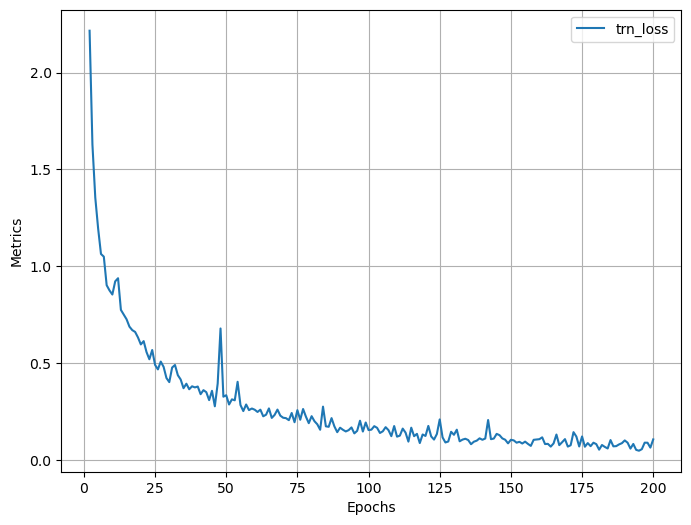

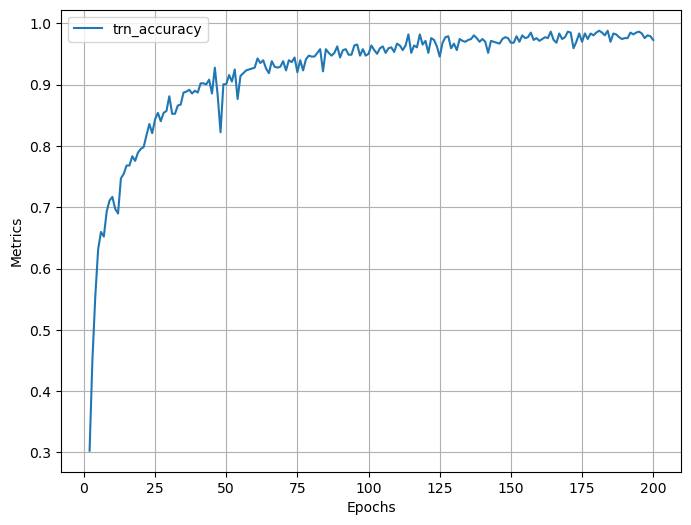

In [27]:
model = ClassificationModel(
    in_channels=3, n_kernels=[16, 32, 64],
    kernel_sizes=[3, 3, 3], fc_neurons=[512, 5],
    activations_path=data_path / Path("Exper/aug")
)
loss_function = nn.CrossEntropyLoss(weight=torch.Tensor([1, 1, 3, 1, 1])).to("cuda")
train_loop(200, model, train_dataloader, 1e-4, loss_function, 100)

100%|██████████| 657/657 [00:03<00:00, 172.75it/s]


[INFO] Metrics for train dataset


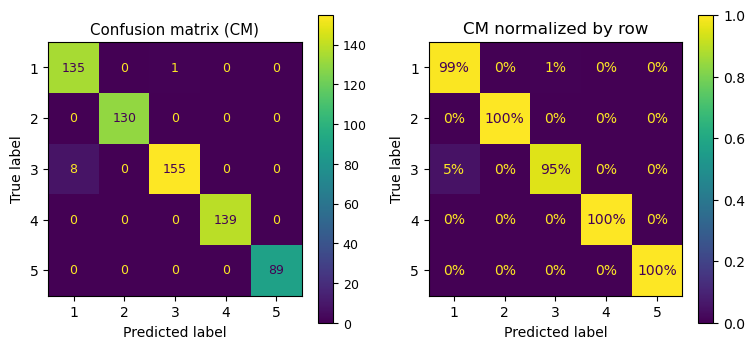

              precision    recall  f1-score   support

   blackspot       0.94      0.99      0.97       136
      canker       1.00      1.00      1.00       130
    greening       0.99      0.95      0.97       163
     healthy       1.00      1.00      1.00       139
    melanose       1.00      1.00      1.00        89

    accuracy                           0.99       657
   macro avg       0.99      0.99      0.99       657
weighted avg       0.99      0.99      0.99       657



In [28]:
predict_and_evaluate(
    model=model,
    data_loader=train_dataloader,
    dataset="train"
)

100%|██████████| 167/167 [00:00<00:00, 172.06it/s]


[INFO] Metrics for test dataset


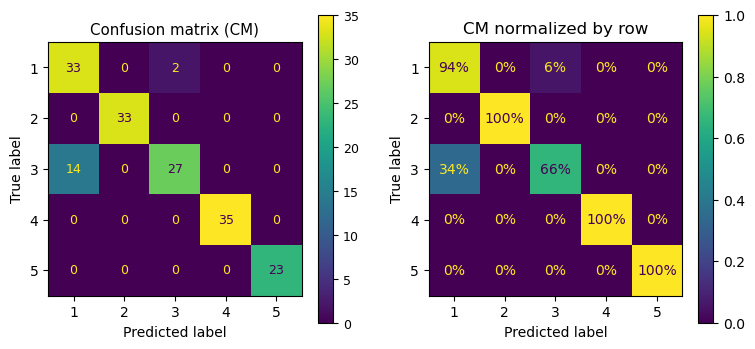

              precision    recall  f1-score   support

   blackspot       0.70      0.94      0.80        35
      canker       1.00      1.00      1.00        33
    greening       0.93      0.66      0.77        41
     healthy       1.00      1.00      1.00        35
    melanose       1.00      1.00      1.00        23

    accuracy                           0.90       167
   macro avg       0.93      0.92      0.92       167
weighted avg       0.92      0.90      0.90       167



In [29]:
predict_and_evaluate(
    model=model,
    data_loader=test_dataloader,
    dataset="test"
)

[INFO] Generating visualizations for Train dataset


100%|██████████| 83/83 [00:18<00:00,  4.52it/s]


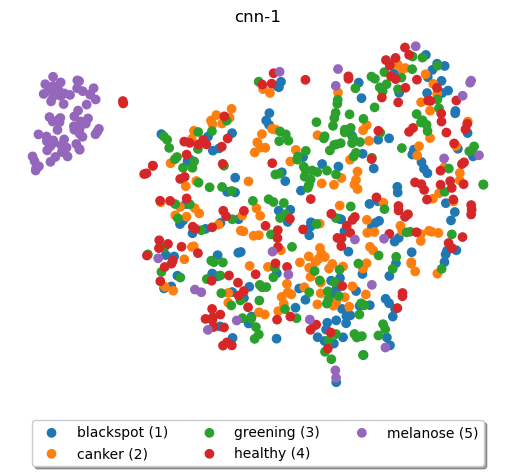

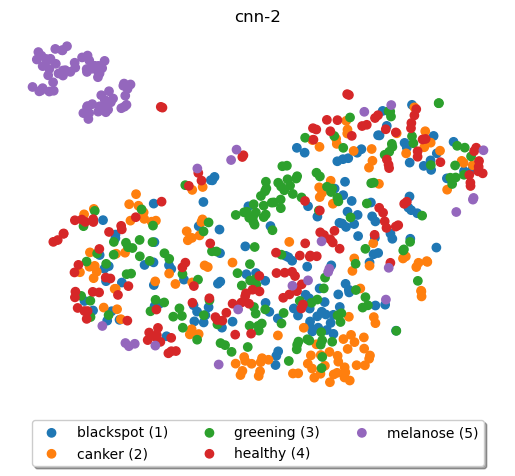

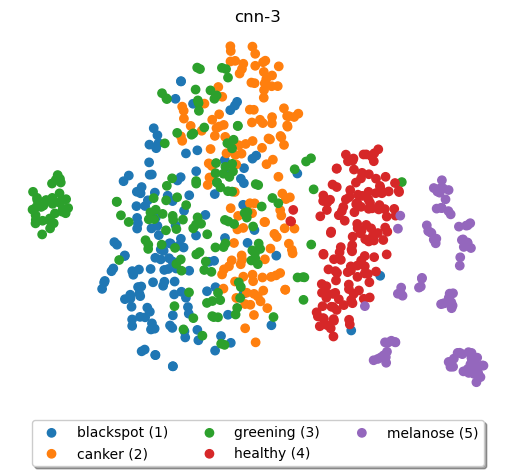

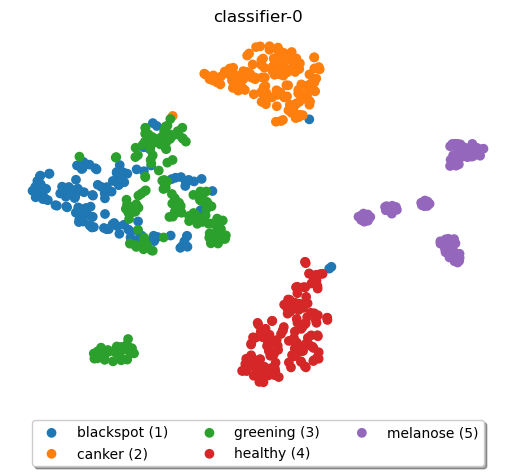

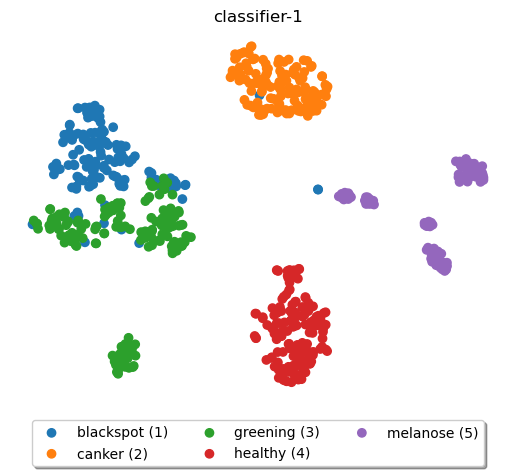

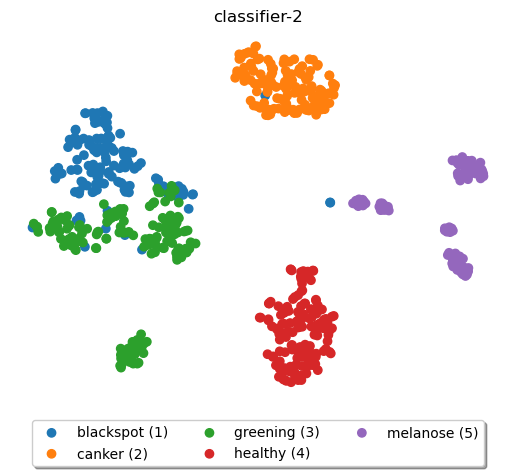

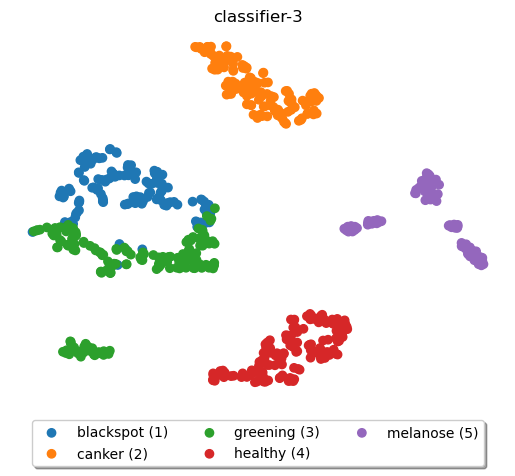

In [30]:
visualize_layers_output(
    model=model,
    data_loader=train_dataloader,
    classes_dict=classes_dict,
    dataset="Train"
)

[INFO] Generating visualizations for Test dataset


100%|██████████| 167/167 [00:05<00:00, 32.13it/s]


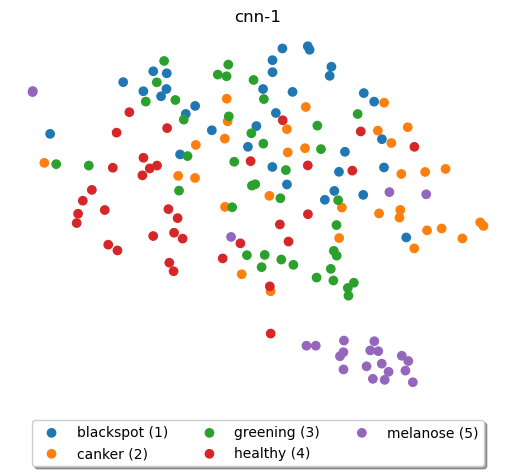

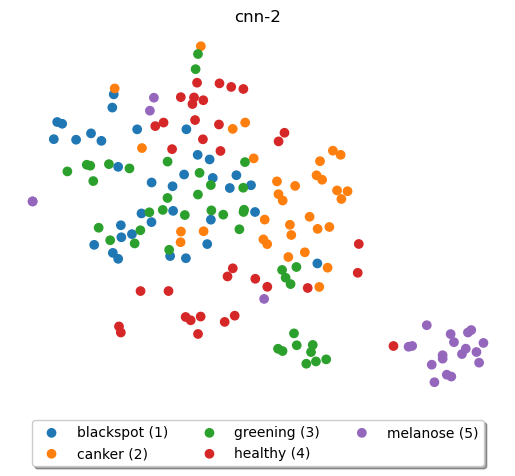

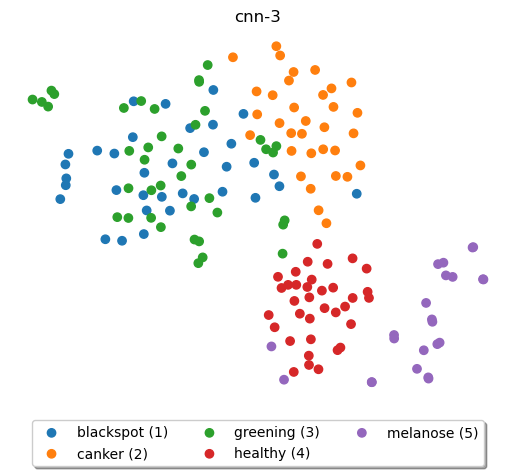

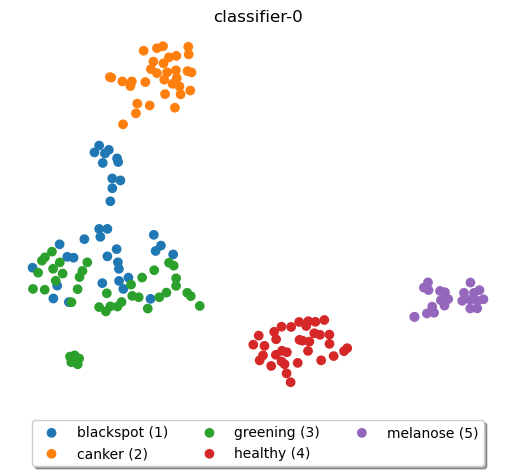

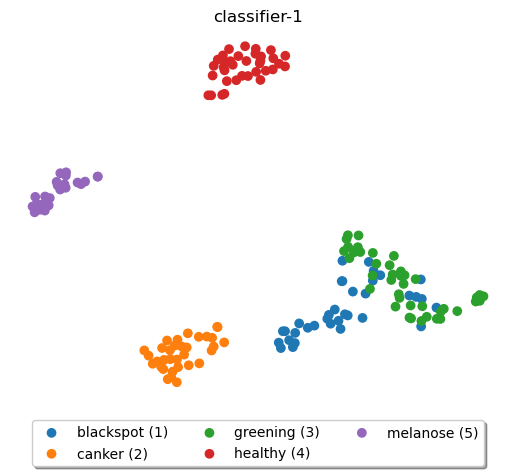

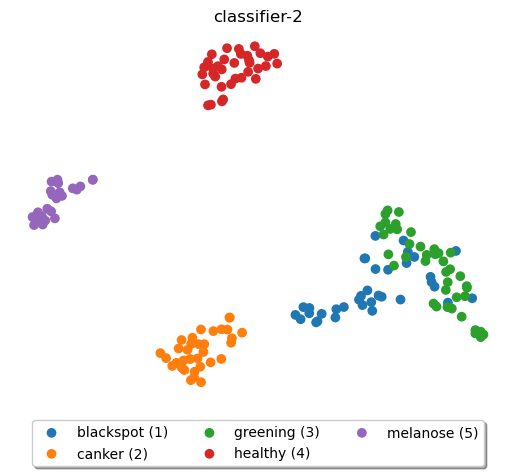

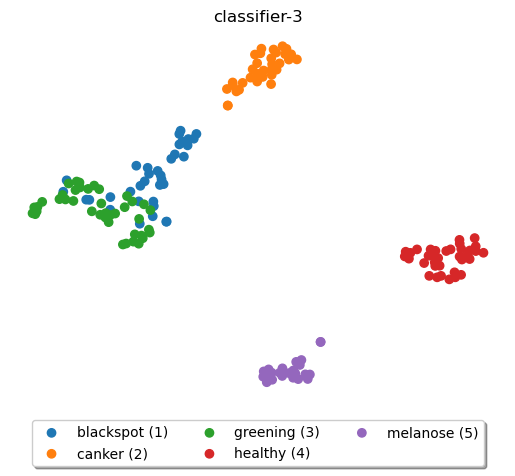

In [31]:
visualize_layers_output(
    model=model,
    data_loader=test_dataloader,
    classes_dict=classes_dict,
    dataset="Test"
)

# Extra - Activities

- Try different classes weights (cross entropy loss) and verify if you can improve model's performance for all classes
- Modify augmentations and verify if you improve model's generalization
- Test different configurations for your model (e.g., number of filters, filters size, number of neurons for the hidden layer) and verify if you can improve model's performance
- Verify if you can improve separability of classes on the projections (Classifiers)